In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
vehicles = sns.load_dataset("mpg").rename(columns={"horsepower":"hp"}).dropna().sort_values("hp")
vehicles.head()

,mpg,cylinders,displacement,hp,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


In [4]:
X = vehicles[["hp"]]
X["hp^2"] = vehicles["hp"]**2
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4

Y = vehicles["mpg"]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,
                                                    test_size=0.2,
                                                    random_state=100,
                                                    shuffle=True)
print(f"Size of full dataset: {X.shape[0]} points")
print(f"Size of training set: {X_train.shape[0]} points")
print(f"Size of test set: {X_test.shape[0]} points")

Size of full dataset: 392 points
Size of training set: 313 points
Size of test set: 79 points


In [6]:
import sklearn.linear_model as lm

model = lm.LinearRegression()

model.fit(X_train, Y_train)

LinearRegression()

In [7]:
from sklearn.metrics import mean_squared_error

train_error = mean_squared_error(Y_train, model.predict(X_train))
test_error = mean_squared_error(Y_test, model.predict(X_test))

print(f"Training error: {train_error}")
print(f"Test error: {test_error}")

Training error: 18.34167355487827
Test error: 21.527475812703674


In [8]:
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=100)

print(f"Size of original training set: {X_train.shape[0]} points")
print(f"Size of mini training set: {X_train_mini.shape[0]} points")
print(f"Size of validation set: {X_val.shape[0]} points")

Size of original training set: 313 points
Size of mini training set: 250 points
Size of validation set: 63 points


In [9]:
X_train_mini

,hp,hp^2,hp^3,hp^4
324,65.0,4225.0,274625.0,1.785062e+07
187,140.0,19600.0,2744000.0,3.841600e+08
397,82.0,6724.0,551368.0,4.521218e+07
284,110.0,12100.0,1331000.0,1.464100e+08
181,53.0,2809.0,148877.0,7.890481e+06
...,...,...,...,...
339,84.0,7056.0,592704.0,4.978714e+07
70,190.0,36100.0,6859000.0,1.303210e+09
253,95.0,9025.0,857375.0,8.145062e+07
272,85.0,7225.0,614125.0,5.220062e+07


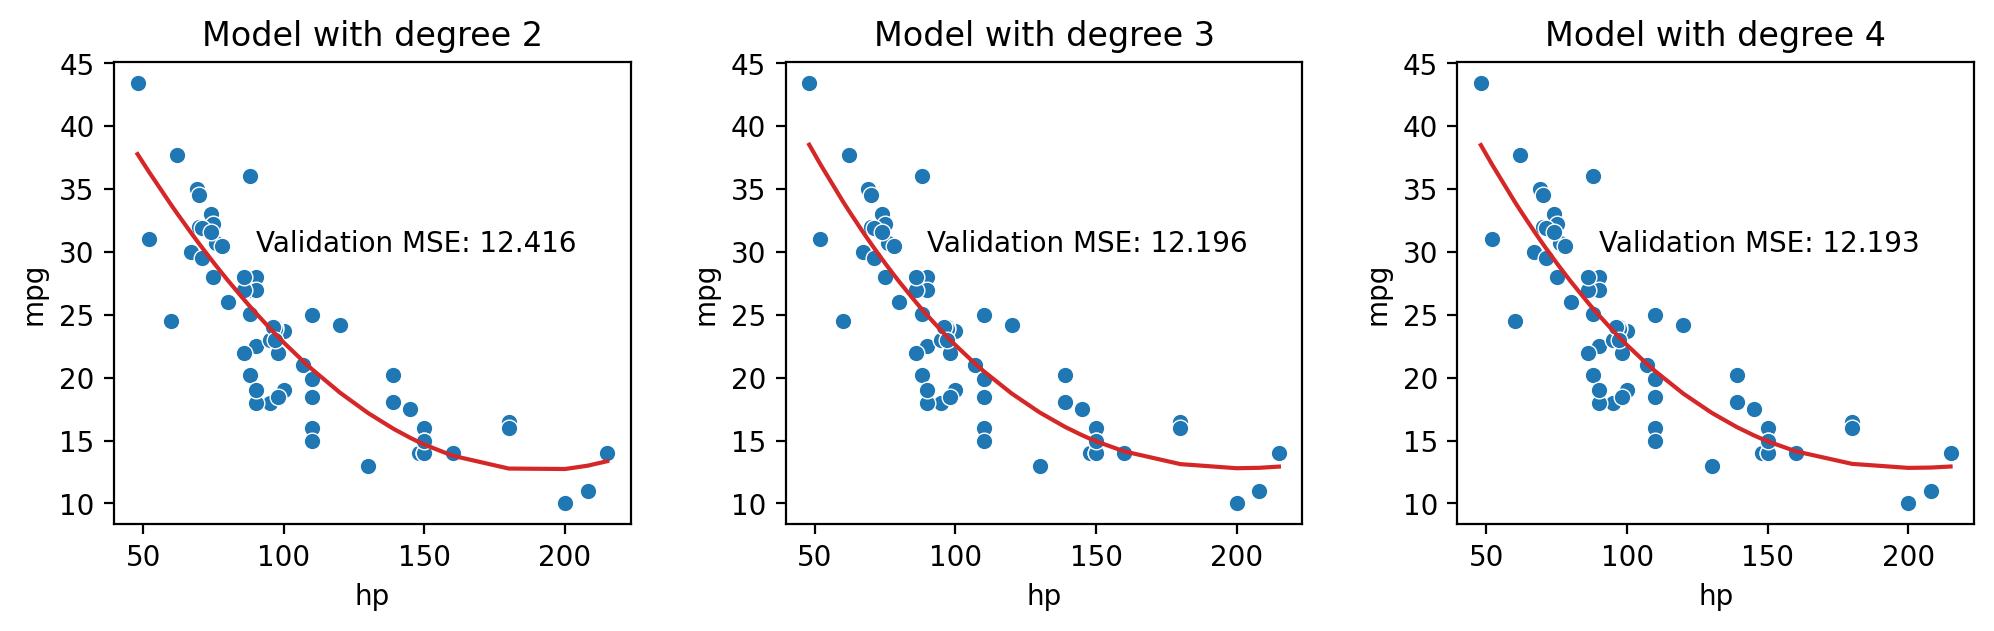

In [10]:
fig, ax = plt.subplots(1,3, dpi=200, figsize=(12,3))

for order in [2,3,4]:
  model = lm.LinearRegression()
  model.fit(X_train_mini.iloc[:, :order], Y_train_mini)
  val_predictions = model.predict(X_val.iloc[:, :order])

  output = X_val.iloc[:, :order]
  output["y_hat"] = val_predictions
  output = output.sort_values("hp")

  ax[order-2].scatter(X_val["hp"], Y_val, edgecolor="white", lw=0.5)
  ax[order-2].plot(output["hp"], output["y_hat"], "tab:red")
  ax[order-2].set_title(f"Model with degree {order}")
  ax[order-2].set_xlabel("hp")
  ax[order-2].set_ylabel("mpg")
  ax[order-2].annotate(f"Validation MSE: {np.round(mean_squared_error(Y_val, val_predictions), 3)}", (90, 30))

plt.subplots_adjust(wspace=0.3);

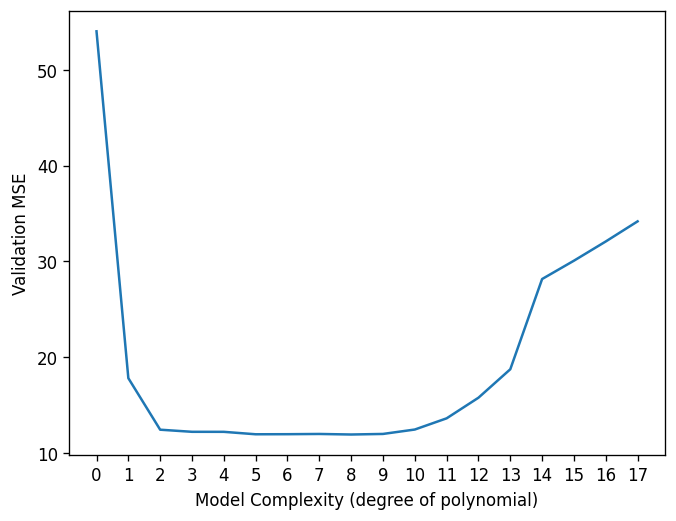

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree):
  pipelined_model = Pipeline([
      ('polynomial_transformation', PolynomialFeatures(degree)),
      ('linear_regression', lm.LinearRegression())
  ])
  pipelined_model.fit(X_train_mini[["hp"]], Y_train_mini)
  return mean_squared_error(Y_val, pipelined_model.predict(X_val[["hp"]]))

errors = [fit_model_dataset(degree) for degree in range(0,18)]
MSEs_and_k = pd.DataFrame({"k" : range (0,18), "MSE": errors})

plt.figure(dpi=120)
plt.plot(range(0, 18), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Validation MSE")
plt.xticks(range(0,18));

In [12]:
MSEs_and_k.rename(columns={"k": "Degree"}).set_index("Degree")

,MSE
Degree,
0,54.024495
1,17.798108
2,12.415902
3,12.196206
4,12.192597
5,11.938316
6,11.945792
7,11.970525
8,11.913837


In [13]:
print(f'Polynomial degree with lowest validation error: {MSEs_and_k.sort_values("MSE").head(1)["k"].values}')

Polynomial degree with lowest validation error: [8]


In [15]:
for degree in range(5,9):
  X_train[f"hp^{degree}"] = X_train["hp"]**degree
  X_test[f"hp^{degree}"] = X_test["hp"]**degree

final_model = lm.LinearRegression()
final_model.fit(X_train, Y_train)

print(f"Test MSE of final model: {mean_squared_error(Y_test, final_model.predict(X_test))}")

Test MSE of final model: 20.679023906721834


In [16]:
for i in range(1,4):
  X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
  model = lm.LinearRegression()
  model.fit(X_train_mini, Y_train_mini)
  y_hat = model.predict(X_val)
  print(f"Val error from train/validation split #{i}: {mean_squared_error(y_hat, Y_val)}")

Val error from train/validation split #1: 15.308956817132765
Val error from train/validation split #2: 17.118728637298872
Val error from train/validation split #3: 15.33710250935317


In [17]:
from sklearn.model_selection import KFold
np.random.seed(25)

kf = KFold(n_splits=5, shuffle=True)
validation_errors = []

for train_idx, valid_idx in kf.split(X_train):
  split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
  split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

  model.fit(split_X_train, split_Y_train)

  error = mean_squared_error(model.predict(split_X_valid), split_Y_valid)

  validation_errors.append(error)

print(f"Cross-validation error: {np.mean(validation_errors)}")

Cross-validation error: 18.6156870377782


In [18]:
import sklearn.linear_model as lm
lasso_model = lm.Lasso(alpha=0.1)
lasso_model.fit (X_train, Y_train)

lasso_model.coef_

array([-5.14100640e-01,  1.16422594e-03,  2.70209864e-06, -8.05153574e-10,
       -2.78280269e-11, -1.02040718e-13, -5.44295812e-17,  1.83589942e-18])

In [19]:
lasso_model_large_lambda = lm.Lasso(alpha=10)
lasso_model_large_lambda.fit(X_train, Y_train)

lasso_model_large_lambda.coef_

array([-0.00000000e+00, -3.37446532e-03,  1.31817186e-05,  1.71062658e-08,
       -2.44893438e-11, -2.11314339e-13, -5.38994214e-16,  7.05457777e-19])

In [20]:
X_train.head()

,hp,hp^2,hp^3,hp^4,hp^5,hp^6,hp^7,hp^8
72,150.0,22500.0,3375000.0,5.062500e+08,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17
89,150.0,22500.0,3375000.0,5.062500e+08,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17
92,158.0,24964.0,3944312.0,6.232013e+08,9.846580e+10,1.555760e+13,2.458100e+15,3.883799e+17
124,180.0,32400.0,5832000.0,1.049760e+09,1.889568e+11,3.401222e+13,6.122200e+15,1.101996e+18
88,137.0,18769.0,2571353.0,3.522754e+08,4.826172e+10,6.611856e+12,9.058243e+14,1.240979e+17


In [21]:
pd.DataFrame({"Feature":X_train.columns, "Parameter": lasso_model.coef_})

,Feature,Parameter
0,hp,-5.141006e-01
1,hp^2,1.164226e-03
2,hp^3,2.702099e-06
3,hp^4,-8.051536e-10
4,hp^5,-2.782803e-11
5,hp^6,-1.020407e-13
6,hp^7,-5.442958e-17
7,hp^8,1.835899e-18


In [22]:
X_train_centered = X_train - X_train.mean()

X_train_standardized = X_train_centered/X_train_centered.std()

X_train_centered.head()

,hp,hp^2,hp^3,hp^4,hp^5,hp^6,hp^7,hp^8
72,44.559105,9846.667732,1.656254e+06,2.465092e+08,3.320483e+10,3.887583e+12,3.243667e+14,-8.983933e+15
89,44.559105,9846.667732,1.656254e+06,2.465092e+08,3.320483e+10,3.887583e+12,3.243667e+14,-8.983933e+15
92,52.559105,12310.667732,2.225566e+06,3.634604e+08,5.573313e+10,8.054556e+12,1.073873e+15,1.231069e+17
124,74.559105,19746.667732,4.113254e+06,7.900192e+08,1.462241e+11,2.650918e+13,4.737973e+15,8.367231e+17
88,31.559105,6115.667732,8.526069e+05,9.253451e+07,5.529054e+09,-8.911854e+11,-4.784028e+14,-1.411751e+17


In [23]:
lasso_model_scaled = lm.Lasso(alpha=0.1)
lasso_model_scaled.fit(X_train_centered, Y_train)
lasso_model_scaled.coef_

array([-5.14100640e-01,  1.16422594e-03,  2.70209864e-06, -8.05153574e-10,
       -2.78280269e-11, -1.02040718e-13, -5.44295812e-17,  1.83589942e-18])

In [24]:
ridge_model = lm.Ridge(alpha=0.1)
ridge_model.fit(X_train_standardized, Y_train)

ridge_model.coef_

array([-16.85961652,   3.26398097,   9.1167183 ,   4.53790201,
        -2.32110639,  -5.6066523 ,  -3.15831859,   4.75104822])